In [1]:
%load_ext line_profiler

In [14]:
import sys
import math
from collections import defaultdict

import uproot
import numpy as np

import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.ticker as tick
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import logging
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

In [25]:
def ratio_err(num, den, num_err, den_err):
    n, d, n_e, d_e = num, den, num_err, den_err
    return np.array([
        n[i] / d[i] * math.sqrt((n_e[i] / n[i])**2 + (d_e[i] / d[i])**2)
        for i in range(len(num))
    ])


def is_fiducial(x, y, z):
    try:
        x_1 = x[:, 0] > 10
        x_2 = x[:, 1] > 10
        y_1 = y[:, 0] > 15
        y_2 = y[:, 1] > 15
        z_1 = z[:, 0] > 10
        z_2 = z[:, 1] > 50

        return x_1 & x_2 & y_1 & y_2 & z_1 & z_2
    except IndexError:
        return True

def select_showers(variable, variable_name, sample, score=0.5):

    if type(variable) != type(np.array([])):
        variable = np.hstack(variable)
        if "shr" in variable_name:
            shr_score = selection("trkshr_score_v", sample)
            shr_score = shr_score.flatten()
            print(len(shr_score), len(variable))
            shr_score_id = np.where(shr_score < 0.5)
            variable = variable[shr_score_id]

    return variable


def selection(variable, mc, extra_cut=[]):
    nslice = mc.array("nslice") == 1
    ntrack = mc.array("ntrack") > 0
    nshower = mc.array("nshower") > 0
    
    pfnhits = mc.array("pfnhits")
    pfnhits_planes = mc.array("pfnplanehits")
    topology = ntrack & nshower

    nhits = np.array([sum(pfp_hits) > 5 for pfp_hits in pfnhits])

    selected = nslice & topology & nhits 
    
    if len(extra_cut) > 0:
        selected = selected & extra_cut

    trk_x = mc.array("dtrk_x_boundary")[selected]
    trk_y = mc.array("dtrk_y_boundary")[selected]
    trk_z = mc.array("dtrk_z_boundary")[selected]

    shr_x = mc.array("dshr_x_boundary")[selected]
    shr_y = mc.array("dshr_y_boundary")[selected]
    shr_z = mc.array("dshr_z_boundary")[selected]

    vtx_x = mc.array("dvtx_x_boundary")[selected]
    vtx_y = mc.array("dvtx_y_boundary")[selected]
    vtx_z = mc.array("dvtx_z_boundary")[selected]
    
#     shr_dedx_y_v = mc.array("shr_dedx_y_v")[selected]
        
#     dedx_cut = np.array([np.all((dedx < 3) & (dedx > 1.4)) for dedx in shr_dedx_y_v])

    fidvol = is_fiducial(trk_x, trk_y, trk_z) & is_fiducial(shr_x, shr_y, shr_z) & is_fiducial(vtx_x, vtx_y, vtx_z)

    return mc.array(variable)[selected][fidvol]


def chisquare(data, mc, err_data, err_mc):
    num = (data-mc)**2
    den = err_mc**2
    return sum(num/den) / np.count_nonzero(data)

    
category_labels = {
    1: r"$\nu_e$ CC",
    11: r"$\nu_e$ CC0$\pi$-Np",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Outside fid. vol.",
    6: r"other",
    0: r"Data"
}

pdg_labels = {
    2212: "$p$",
    13: "$\mu$",
    11: "$e$",
    -13: "$\mu$",
    -11: "$e$",
    211: "$\pi$",
    -211: "$\pi$",
    2112: "$n$",
    22: "$\gamma$",
    321: "$K$",
    -321: "$K$",
    0: "Overlay cosmic"
}

category_colors = ["xkcd:light red", "xkcd:sky blue", "xkcd:cerulean", "xkcd:cobalt",
                   "xkcd:brick", "xkcd:green", "xkcd:lime green", "xkcd:grey"]


In [26]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open("root_files/shrselection_prodgenie_bnb_nu_uboone_overlay_mcc9_postCSU_v08_00_00_12_run1_reco2.root")[fold][tree]
nue = uproot.open("root_files/shrselection_prodgenie_bnb_intrinsic_nue_uboone_overlay_mcc9_TESTv12_C1_reco2.root")[fold][tree]
data = uproot.open("root_files/shrselection_data_bnb_optfilter_C1_5e19_goodruns_v08_00_00_12_reco2.root")[fold][tree]
ext = uproot.open("root_files/shrselection_data_extbnb_mcc9.0_v08_00_00_12_run1_reco2.root")[fold][tree]

samples = {"mc": mc, "nue": nue, "data": data, "ext": ext}
weights = {"mc": 0.05431, "nue": 0.00091, "ext": 0.1571548487}


In [27]:
def categorize_entries_pdg(sample, variable, extra_cut=[]):
    backtracked_pdg = selection("backtracked_pdg", sample, extra_cut=extra_cut)

    if "trk" in variable:
        pfp_id_variable = "trk_pfp_id"
    else:
        pfp_id_variable = "shr_pfp_id"

    pfp_id = selection(pfp_id_variable, sample, extra_cut=extra_cut)
    plotted_variable = selection(variable, sample, extra_cut=extra_cut)
    pfp_id = np.subtract(pfp_id, 1)
    backtracked_pdg = selection("backtracked_pdg", sample, extra_cut=extra_cut)

    plotted_variable = select_showers(plotted_variable, variable, sample)

    pfp_pdg = np.array(
        [pdg[pfp_id] for pdg, pfp_id in zip(backtracked_pdg, pfp_id)])
    pfp_pdg = np.hstack(pfp_pdg)
    pfp_pdg = abs(pfp_pdg)

    return pfp_pdg, plotted_variable


def categorize_entries(sample, variable, extra_cut=[]):
    category = selection("category", sample, extra_cut=extra_cut)
    plotted_variable = selection(variable, sample, extra_cut=extra_cut)

    if type(plotted_variable) != type(np.array([])):
        category = np.array([
            np.array([c] * len(v)) for c, v in zip(category, plotted_variable)
        ])
        category = np.hstack(category)
    plotted_variable = select_showers(plotted_variable, variable, sample)

    return category, plotted_variable


def plot_variable(samples, weights, variable, title, categorization,
                  cat_labels, **plot_options):
    nu_pdg = samples["mc"].array("nu_pdg") != 12
    category, mc_plotted_variable = categorization(
        samples["mc"], variable, extra_cut=nu_pdg)
    mc_weight = [weights["mc"]] * len(mc_plotted_variable)

    var_dict = defaultdict(list)
    weight_dict = defaultdict(list)
    for c, v in zip(category, mc_plotted_variable):
        var_dict[c].append(v)
        weight_dict[c].append(weights["mc"])

    category, nue_plotted_variable = categorization(samples["nue"], variable)
    nue_weight = [weights["nue"]] * len(nue_plotted_variable)
    for c, v in zip(category, nue_plotted_variable):
        var_dict[c].append(v)
        weight_dict[c].append(weights["nue"])

    ext_plotted_variable = selection(variable, samples["ext"])
    ext_plotted_variable = select_showers(ext_plotted_variable, variable, samples["ext"])

    data_plotted_variable = selection(variable, samples["data"])
    data_plotted_variable = select_showers(data_plotted_variable, variable,
                                           samples["data"])

    fig = plt.figure(figsize=(8, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    total = sum(sum(weight_dict[c]) for c in var_dict)
    total += sum([weights["ext"]] * len(ext_plotted_variable))
    labels = [
        "%s: %.1f%%" % (cat_labels[c], sum(weight_dict[c]) / total * 100)
        for c in var_dict.keys()
    ]

    ax1.hist(
        var_dict.values(),
        **plot_options,
        weights=list(weight_dict.values()),
        stacked=True,
        label=labels)

    total_array = np.concatenate(list(var_dict.values()))
    total_weight = np.concatenate(list(weight_dict.values()))

    plot_options.pop('color', None)

    total_hist, total_bins = np.histogram(
        total_array, **plot_options, weights=total_weight)

    ext_weight = [weights["ext"]] * len(ext_plotted_variable)
    n_ext, ext_bins, patches = ax1.hist(
        ext_plotted_variable,
        **plot_options,
        weights=ext_weight,
        bottom=total_hist,
        label="EXT: %.1f%%" %
        (sum([weights["ext"]] * len(ext_plotted_variable)) / total * 100),
        hatch="//",
        color="white")

    total_array = np.concatenate([total_array, ext_plotted_variable])
    total_weight = np.concatenate([total_weight, ext_weight])

    n_tot, bin_edges, patches = ax1.hist(
        total_array,
        **plot_options,
        weights=total_weight,
        histtype="step",
        edgecolor="black")

    bincenters = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mc_uncertainties, bins = np.histogram(mc_plotted_variable, **plot_options)
    err_mc = np.array(
        [n * weights["mc"] * weights["mc"] for n in mc_uncertainties])

    nue_uncertainties, bins = np.histogram(nue_plotted_variable,
                                           **plot_options)
    err_nue = np.array(
        [n * weights["nue"] * weights["nue"] for n in nue_uncertainties])

    err_ext = np.array([n * weights["ext"] * weights["ext"] for n in n_ext])

    exp_err = np.sqrt(err_mc + err_ext + err_nue)
    bin_size = [(bin_edges[i + 1] - bin_edges[i]) / 2
                for i in range(len(bin_edges) - 1)]
    ax1.bar(bincenters, n_tot, width=0, yerr=exp_err)

    n_data, bins = np.histogram(data_plotted_variable, **plot_options)
    data_err = np.sqrt(n_data)
    ax1.errorbar(
        bincenters,
        n_data,
        xerr=bin_size,
        yerr=data_err,
        fmt='ko',
        label="BNB: %i events" % sum(n_data))

    leg = ax1.legend(
        frameon=False, ncol=2, title=r'MicroBooNE Preliminary 4.5e19 POT')
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(), fontweight='bold')

    unit = title[title.find("[") +
                 1:title.find("]")] if "[" and "]" in title else ""
    xrange = plot_options["range"][1] - plot_options["range"][0]
    ax1.set_ylabel(
        "N. Entries / %g %s" % (xrange / plot_options["bins"], unit))
    ax1.set_xticks([])
    ax1.set_xlim(plot_options["range"][0], plot_options["range"][1])

    draw_ratio(ax2, bins, n_tot, n_data, exp_err, data_err)
    
    ax2.text(
        0.88,
        0.845,
        r'$\chi^2 /$n.d.f. = %.2f' % chisquare(n_data, n_tot, data_err, exp_err) +
        '\n' +
        'K.S. prob. = %.2f' % scipy.stats.ks_2samp(n_data, n_tot)[1],
        va='center',
        ha='center',
        ma='right',
        fontsize=12,
        transform=ax2.transAxes)

    ax2.set_xlabel(title)
    ax2.set_xlim(plot_options["range"][0], plot_options["range"][1])
    fig.tight_layout()
    fig.savefig("plots/%s_cat.pdf" % variable)
    return fig, ax1, ax2


def plot_variable_samples(samples, weights, variable, title, **plot_options):
    nu_pdg = samples["mc"].array("nu_pdg") != 12

    mc_plotted_variable = selection(variable, samples["mc"], extra_cut=nu_pdg)
    mc_plotted_variable = select_showers(mc_plotted_variable, variable, samples["mc"])
    mc_weight = [weights["mc"]] * len(mc_plotted_variable)

    nue_plotted_variable = selection(variable, samples["nue"])
    nue_plotted_variable = select_showers(nue_plotted_variable, variable, samples["nue"])
    nue_weight = [weights["nue"]] * len(nue_plotted_variable)

    ext_plotted_variable = selection(variable, samples["ext"])
    ext_plotted_variable = select_showers(ext_plotted_variable, variable, samples["ext"])
    ext_weight = [weights["ext"]] * len(ext_plotted_variable)

    data_plotted_variable = selection(variable, samples["data"])
    data_plotted_variable = select_showers(data_plotted_variable, variable, samples["data"])

    total_variable = np.concatenate(
        [mc_plotted_variable, nue_plotted_variable, ext_plotted_variable])
    total_weight = np.concatenate([mc_weight, nue_weight, ext_weight])

    fig = plt.figure(figsize=(8, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    n_mc, mc_bins, patches = ax1.hist(
        mc_plotted_variable,
        **plot_options,
        weights=mc_weight,
        label="BNB overlay: %g entries" % sum(mc_weight))

    n_nue, nue_bins, patches = ax1.hist(
        nue_plotted_variable,
        **plot_options,
        bottom=n_mc,
        weights=nue_weight,
        label=r"$\nu_{e}$ overlay: %g entries" % sum(nue_weight))

    n_ext, ext_bins, patches = ax1.hist(
        ext_plotted_variable,
        **plot_options,
        bottom=n_mc + n_nue,
        weights=ext_weight,
        label="EXT: %g entries" % sum(ext_weight),
        hatch="//",
        color="white")

    n_tot, tot_bins, pateches = ax1.hist(
        total_variable,
        **plot_options,
        weights=total_weight,
        histtype="step",
        edgecolor="black")

    err_mc = np.array([n * weights["mc"] * weights["mc"] for n in n_mc])
    err_nue = np.array([n * weights["nue"] * weights["nue"] for n in n_nue])
    err_ext = np.array([n * weights["ext"] * weights["ext"] for n in n_ext])
    tot_uncertainties = np.sqrt(err_mc + err_ext + err_nue)

    bincenters = 0.5 * (tot_bins[1:] + tot_bins[:-1])
    exp_err = tot_uncertainties
    bin_size = [(tot_bins[i + 1] - tot_bins[i]) / 2
                for i in range(len(tot_bins) - 1)]
    ax1.bar(bincenters, n_tot, width=0, yerr=exp_err)

    n_data, bins = np.histogram(data_plotted_variable, **plot_options)
    data_err = np.sqrt(n_data)
    ax1.errorbar(
        bincenters,
        n_data,
        xerr=bin_size,
        yerr=data_err,
        fmt='ko',
        label="BNB: %i events" % sum(n_data))

    leg = ax1.legend(frameon=False, title=r'MicroBooNE Preliminary 4.5e19 POT')
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(), fontweight='bold')

    unit = title[title.find("[") +
                 1:title.find("]")] if "[" and "]" in title else ""
    xrange = plot_options["range"][1] - plot_options["range"][0]
    ax1.set_ylabel(
        "N. Entries / %g %s" % (xrange / plot_options["bins"], unit))
    ax1.set_xticks([])
    ax1.set_xlim(plot_options["range"][0], plot_options["range"][1])

    draw_ratio(ax2, bins, n_tot, n_data, exp_err, data_err)

    ax2.set_xlabel(title)
    ax2.set_xlim(plot_options["range"][0], plot_options["range"][1])
    fig.tight_layout()
    fig.savefig("plots/%s_samples.pdf" % variable)

    return fig, ax1, ax2


def draw_ratio(ax, bins, n_tot, n_data, tot_err, data_err):
    bincenters = 0.5 * (bins[1:] + bins[:-1])
    bin_size = [(bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)]
    ratio_error = ratio_err(n_data, n_tot, data_err, tot_err)
    ax.errorbar(
        bincenters, n_data / n_tot, xerr=bin_size, yerr=ratio_error, fmt="ko")

    ratio_error_mc = ratio_err(n_tot, n_tot, tot_err, tot_err)
    ratio_error_mc = np.insert(ratio_error_mc, 0, ratio_error_mc[0])
    ax.fill_between(
        bins,
        1 - ratio_error_mc,
        ratio_error_mc + 1,
        step="pre",
        color="grey",
        alpha=0.5)

    ax.set_ylim(0.5, 1.5)
    ax.set_ylabel("BNB / (MC+EXT)")
    ax.axhline(1, linestyle="--", color="k")

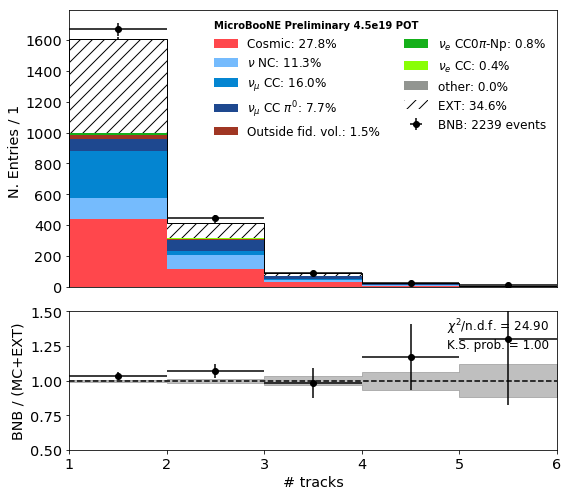

In [28]:
fig, ax1, ax2 = plot_variable(
    samples,
    weights,
    "nshower",
    r"# tracks",
    categorize_entries,
    category_labels,
    color=category_colors,
    bins=5,
    range=(1,6))

fig.savefig("plots/ntrack.pdf")

In [29]:
fig, ax1, ax2 = plot_variable(
    samples,
    weights,
    "shr_dedx_y_v",
    r"Shower dE/dx [MeV/cm]",
    categorize_entries,
    category_labels,
    color=category_colors,
    bins=20,
    range=(0,8))

# ax1.set_ylim(0,600)


KeyError: not found: b'trkshr_score_v'
 in file: root_files/shrselection_prodgenie_bnb_nu_uboone_overlay_mcc9_postCSU_v08_00_00_12_run1_reco2.root